In [1]:
import glob
import random
import os
from torch.utils.data import Dataset
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
import torch
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt

In [2]:
#epoch to start training from
epoch=199
#name of the dataset
dataset_name = 'monet2photo' 
#size of the batches
batch_size=1 
img_height=128 #size of image height
img_width=128 #size of image width
channels=3 #number of image channels
n_residual_blocks=9 #number of residual blocks in generator

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [4]:
input_shape = (channels, img_height, img_width)
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)

cuda = torch.cuda.is_available()
if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    
G_AB.load_state_dict(torch.load("saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch)))
G_BA.load_state_dict(torch.load("saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch)))

<All keys matched successfully>

In [5]:
## 定义一个读取风格图像或内容图像的函数，并且将图像进行表转化
def load_image(img_path, max_size=400, shape=None):
    """
    读取图像并且保证图像的高和宽都小于400
    """
    image = Image.open(img_path).convert('RGB')
    ## 如果图像尺寸过大，就对图像进行尺寸转换
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    ## 如果指定了图像的尺寸，就将图像转化为shape指定的尺寸
    if shape is not None:
        size = shape
    ## 使用transforms将图像转化为张量，并进行标准化
    in_transform = transforms.Compose(
        [transforms.Resize(size), # 图像尺寸变换,图像的短边匹配size
         transforms.ToTensor(), # 数组转化为张量
         ## 图像进行标准化
         transforms.Normalize((0.485, 0.456, 0.406), 
                              (0.229, 0.224, 0.225))])
    # 使用图像的RGB通道，并且添加batch纬度
    image = in_transform(image)[:3,:,:].unsqueeze(dim=0)   
    return image

In [6]:
# 定义一个将标准化后的图像转化为便于利用matplotlib可视化的函数
def im_convert(tensor):
    """ 
    将[1, c, h, w]纬度的张量转化为[ h, w,c]的数组
    因为张量进行了表转化，所以要进行标准化逆变换
    """
    image = tensor.data.numpy().squeeze() # 去处batch纬度数据
    image = image.transpose(1,2,0) ## 置换数组的纬度[c,h,w]->[h,w,c]
    ## 进行标准化的逆操作
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) ##  将图像的取值剪切到0～1之间
    return image

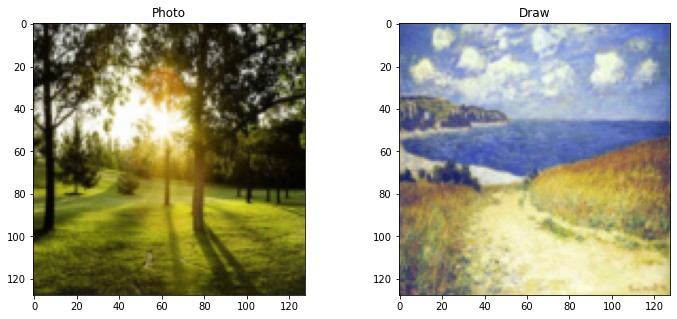

In [7]:
# 读取内容和风格图像
photo = load_image("monet2photo/testB/2014-08-01 17_41_55.jpg",max_size=128)
draw = load_image("monet2photo/testA/00010.jpg",max_size=128)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# content and style ims side-by-side
ax1.imshow(im_convert(photo))
ax1.set_title("Photo")
ax2.imshow(im_convert(draw))
ax2.set_title("Draw")
plt.show()

In [8]:
fake_B = G_AB(draw.cuda())
fake_A = G_BA(photo.cuda())

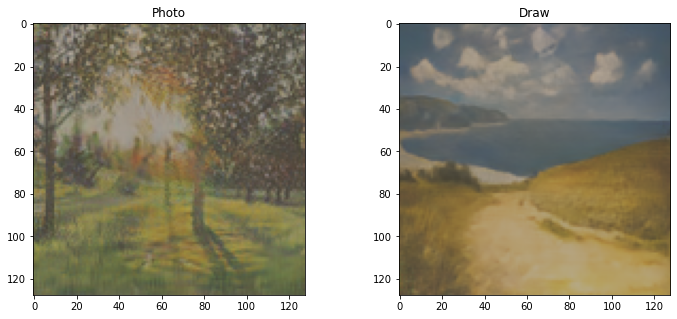

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# content and style ims side-by-side
ax1.imshow(im_convert(fake_A.cpu()))
ax1.set_title("Photo")
ax2.imshow(im_convert(fake_B.cpu()))
ax2.set_title("Draw")
plt.show()